In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from datasets import load_dataset

In [51]:
dataset = load_dataset("imagefolder", data_dir="../experimental/imgs/", split='train')

Resolving data files:   0%|          | 0/373 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/yusuke-fukasawa/.cache/huggingface/datasets/imagefolder/default-b06aeae01fbf6bd1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [52]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 373
})

In [53]:
split_dataset = dataset.train_test_split(test_size=0.1)

In [32]:
from transformers import SwinForImageClassification, SwinConfig, TrainingArguments, Trainer

In [54]:
from datasets import load_metric

metric = load_metric("accuracy")

In [34]:
example = split_dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=105x100>,
 'label': 11}

In [55]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
feature_extractor

/Users/yusuke-fukasawa/Library/Caches/pypoetry/virtualenvs/poke-battle-logger-xYV7PrtE-py3.10/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [56]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size["width"], feature_extractor.size["height"])),
            CenterCrop((feature_extractor.size["width"], feature_extractor.size["height"])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [57]:
labels = split_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'アラブルタケ'

In [58]:
train_ds = split_dataset['train']
val_ds = split_dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [59]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([130, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([130]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
model_name = "pokemon_image_classifier"
batch_size = 16

args = TrainingArguments(
    model_name,
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [61]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [62]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [63]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [64]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/yusuke-fukasawa/Library/Caches/pypoetry/virtualenvs/poke-battle-logger-xYV7PrtE-py3.10/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,4.874489,0.000000
1,4.828700,4.585890,0.078947
2,4.828700,4.156977,0.210526
4,3.958300,3.441757,0.368421
4,3.958300,2.856235,0.473684
5,2.617500,2.439745,0.578947
6,2.617500,2.050938,0.710526
8,1.534100,1.671880,0.736842
8,1.534100,1.409411,0.815789
9,0.951900,1.220069,0.868421


***** train metrics *****
  epoch                    =       19.05
  total_flos               = 466293758GF
  train_loss               =      1.6266
  train_runtime            =  0:25:48.91
  train_samples_per_second =       4.326
  train_steps_per_second   =       0.065


In [65]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =      19.05
  eval_accuracy           =     0.9211
  eval_loss               =     0.8465
  eval_runtime            = 0:00:03.77
  eval_samples_per_second =     10.079
  eval_steps_per_second   =      0.796


In [67]:
# 推論テスト
import cv2
from PIL import Image
from transformers import pipeline

classifier_pipe = pipeline(task="image-classification", model=trainer.model, feature_extractor=feature_extractor)
pokemon_image = cv2.imread("../template_images/user_labeled_pokemon_templates/ヒスイヌメルゴン/20230719104544.png")
pokemon_image2 = cv2.cvtColor(pokemon_image, cv2.COLOR_BGR2RGB)
pokemon_image3 = Image.fromarray(pokemon_image2)
classifier_pipe(pokemon_image3)

[{'score': 0.7885446548461914, 'label': 'ヒスイヌメルゴン'},
 {'score': 0.05843853950500488, 'label': 'ベトベトン'},
 {'score': 0.03541574254631996, 'label': 'ヌメルゴン'},
 {'score': 0.005886880215257406, 'label': 'ブリムオン'},
 {'score': 0.004915282595902681, 'label': 'アーマーガア'}]

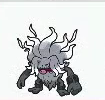

In [21]:
val_ds[0]['image']

In [22]:
classifier_pipe(val_ds[0]['image'])

[{'score': 0.9620992541313171, 'label': 'コノヨザル'},
 {'score': 0.0023251050151884556, 'label': 'パルデアケンタロス水'},
 {'score': 0.0022826222702860832, 'label': 'ルカリオ'},
 {'score': 0.0018290223088115454, 'label': 'フワライド'},
 {'score': 0.0014076568186283112, 'label': 'ペルシアン'}]

In [23]:
for idx, _val in enumerate(val_ds):
    predict = classifier_pipe(_val['image'])
    _label = id2label[_val["label"]]
    print(idx, predict[0], _label)

0 {'score': 0.9620992541313171, 'label': 'コノヨザル'} コノヨザル
1 {'score': 0.9459688067436218, 'label': 'ディンルー'} ディンルー
2 {'score': 0.29056262969970703, 'label': 'アマージョ'} アマージョ
3 {'score': 0.7089477777481079, 'label': 'ルガルガンたそがれ'} ルガルガンたそがれ
4 {'score': 0.9773844480514526, 'label': 'サーフゴー'} サーフゴー
5 {'score': 0.6486186981201172, 'label': 'ピカチュウ'} ピカチュウ
6 {'score': 0.5898177027702332, 'label': 'チオンジェン'} チオンジェン
7 {'score': 0.14921249449253082, 'label': 'タイカイデン'} タイカイデン
8 {'score': 0.17319582402706146, 'label': 'イルカマン'} イルカマン
9 {'score': 0.7456134557723999, 'label': 'カバルドン'} カバルドン
10 {'score': 0.9944936633110046, 'label': 'ディンルー'} ディンルー
11 {'score': 0.9897727370262146, 'label': 'ヌメルゴン'} ヌメルゴン
12 {'score': 0.9222886562347412, 'label': 'バンギラス'} バンギラス
13 {'score': 0.29056262969970703, 'label': 'アマージョ'} アマージョ
14 {'score': 0.9799440503120422, 'label': 'サーフゴー'} サーフゴー
15 {'score': 0.19366687536239624, 'label': 'ライチュウ'} サンダー
16 {'score': 0.49885571002960205, 'label': 'マスカーニャ'} マスカーニャ
17 {'score': 0.9482409

In [48]:
from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="pokemon_image_classifier/config.json",
    path_in_repo="config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)

'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F23/config.json'

In [68]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/pytorch_model.bin",
    path_in_repo="pytorch_model.bin",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/348M [00:00<?, ?B/s]

'https://huggingface.co/fufufukakaka/pokemon_image_classifier/blob/refs%2Fpr%2F26/pytorch_model.bin'

In [50]:
upload_file(
    path_or_fileobj="pokemon_image_classifier/preprocessor_config.json",
    path_in_repo="preprocessor_config.json",
    repo_id="fufufukakaka/pokemon_image_classifier",
    create_pr=1
)